In [1]:
import pandas as pd
import ast
import seaborn as sns
import requests
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score


In [2]:
bec_results = pd.read_csv('cast_bechdel_results.csv')

In [3]:
bec_results['release_date']

0       1919
1       1920
2       1921
3       1921
4       1922
        ... 
4220    2017
4221    2017
4222    2017
4223    2016
4224    2017
Name: release_date, Length: 4225, dtype: int64

In [4]:
bec_results['passes_test'] = np.where(bec_results['rating'] == 3, "Passes", "Fails")
bec_results['passes_test_binary'] = np.where(bec_results['passes_test'] == "Passes", 1, 0)

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

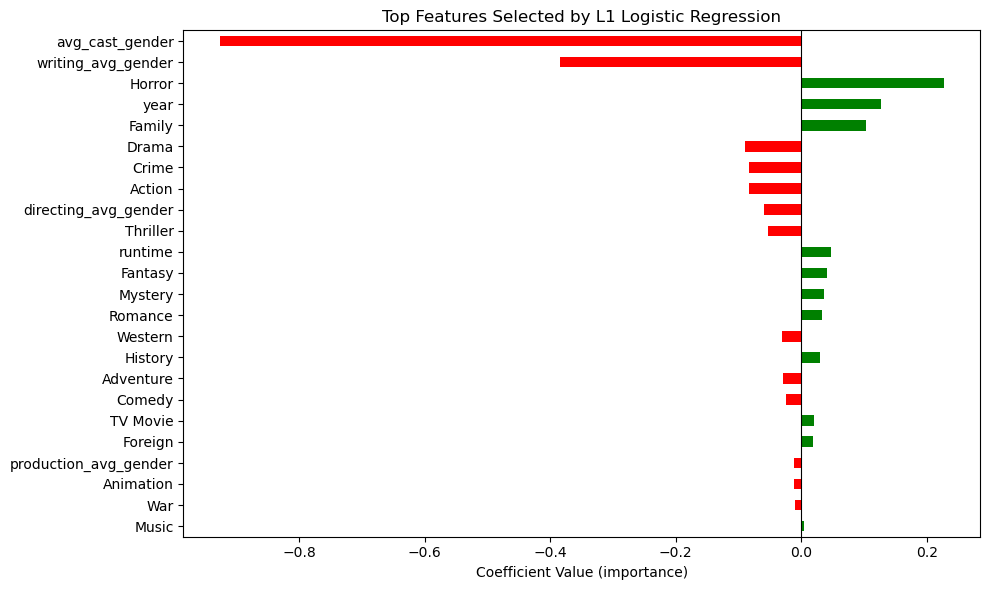

In [ ]:
X = bec_results[['year', 'runtime',
        'Western', 'Romance', 'War', 'Crime', 'TV Movie',
       'Foreign', 'History', 'Thriller', 'Action', 'Horror', 'Fantasy',
       'Animation', 'Adventure', 'Mystery', 'Drama', 'Family', 'Music',
       'Comedy', 'avg_cast_gender', 'directing_avg_gender',
       'production_avg_gender', 'writing_avg_gender']]  # predictors
y = bec_results['passes_test_binary']  # binary target

#Standardize features and split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test)       

#Fit L1 logistic regression
#starting with a relatively high c value to see if all the features are kept
model = LogisticRegression(penalty='l1', solver='liblinear', C=1.0)  # C is inverse of regularization strength
model.fit(X_train, y_train)

# Get important features
coef = model.coef_[0]
feature_names = X.columns
important_features = pd.Series(coef, index=feature_names)
selected_features = important_features[important_features != 0]
sorted_fetures = selected_features.reindex(selected_features.abs().sort_values(ascending=False).index)

# Plot as a horizontal bar chart
plt.figure(figsize=(10, 6))
sorted_fetures.plot(kind='barh', color=np.where(sorted_fetures > 0, 'green', 'red'))

plt.title("Top Features Selected by L1 Logistic Regression")
plt.xlabel("Coefficient Value (importance)")
plt.gca().invert_yaxis()  # Most important at top
plt.axvline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()

This is everything, so it seems like our c value is too high. So next we tried something to get us the best value of c so we could see the most important features

In [7]:
coefficients = model.coef_[0]  # for binary classification, it's a 1D array

# Create a Pandas Series for easy inspection
coef_series = pd.Series(coefficients, index=feature_names)


excluded_features = coef_series[coef_series == 0.0]
print("Features excluded (coef = 0):")
print(excluded_features)

Features excluded (coef = 0):
Series([], dtype: float64)


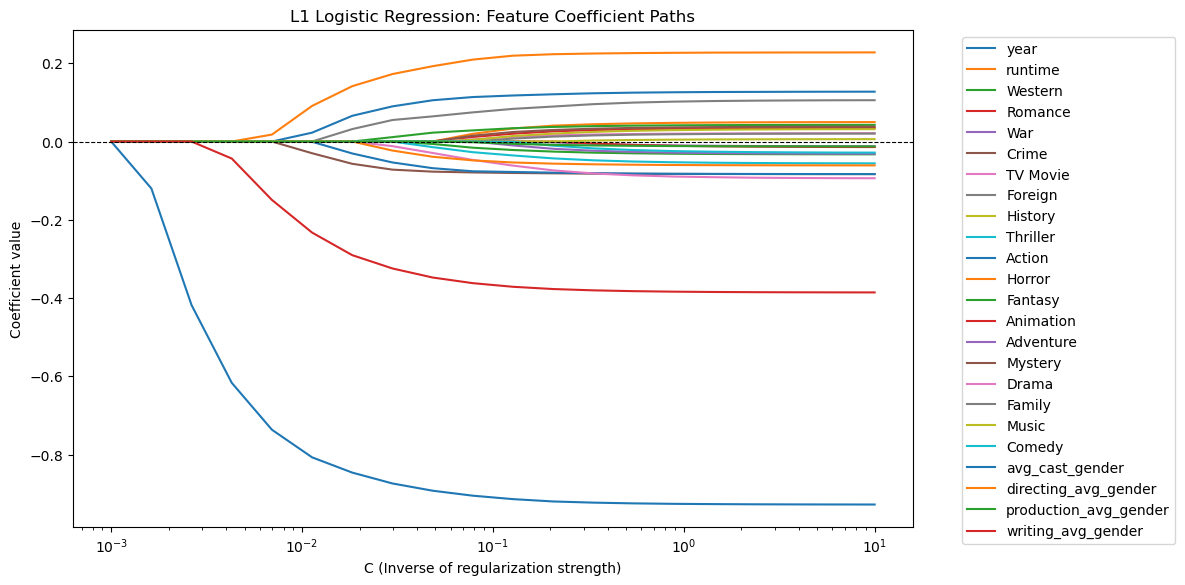

In [8]:
feature_names = X.columns

# Define a range of C values (log scale: stronger to weaker regularization)
C_values = np.logspace(-3, 1, 20)  # from 0.001 to 10

# Store coefficients
coefs = []

for C in C_values:
    model = LogisticRegression(penalty='l1', solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    coefs.append(model.coef_[0])

# Convert to DataFrame for plotting
coefs_df = pd.DataFrame(coefs, columns=feature_names, index=C_values)

# Plotting
plt.figure(figsize=(12, 6))
for feature in feature_names:
    plt.plot(C_values, coefs_df[feature], label=feature)

plt.xscale('log')
plt.xlabel('C (Inverse of regularization strength)')
plt.ylabel('Coefficient value')
plt.title('L1 Logistic Regression: Feature Coefficient Paths')
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
plt.tight_layout()
plt.show()

The following code uses the Logistic Regression CV model which cross validates the model(still just on the training data) in order to figure out the best value of C. This is conceptually similar to lasso regression, which we couldn't do since our output is binary. C is similar to lambda, but instead a larger value corresponds to more features being selected. 

In [9]:
from sklearn.linear_model import LogisticRegressionCV

model_cv = LogisticRegressionCV(
    penalty='l1',
    solver='liblinear',
    Cs=[0.01, 0.05, 0.1, 0.5, 1.0],
    cv=5,
    scoring='accuracy',
    random_state=42
)
model_cv.fit(X_train, y_train)

# View best C and selected features
print("Best C:", model_cv.C_[0])
coef_series = pd.Series(model_cv.coef_[0], index=X.columns)
print("Selected features:", coef_series[coef_series != 0.0].index.tolist())

Best C: 0.05
Selected features: ['year', 'runtime', 'Western', 'Crime', 'Thriller', 'Action', 'Horror', 'Fantasy', 'Mystery', 'Drama', 'Family', 'avg_cast_gender', 'directing_avg_gender', 'writing_avg_gender']


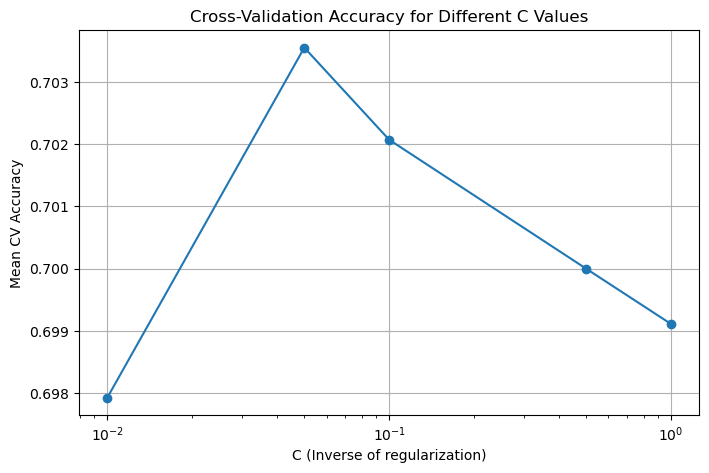

In [10]:
scores = model_cv.scores_[1]  # shape: (n_folds, n_Cs)
C_values = model_cv.Cs_       # the list of C values used

# Convert to DataFrame for readability
scores_df = pd.DataFrame(scores, columns=C_values)
scores_df.index.name = 'Fold'
scores_df.columns.name = 'C'

# Plot mean accuracy vs. C
mean_scores = scores_df.mean(axis=0)

plt.figure(figsize=(8, 5))
plt.plot(C_values, mean_scores, marker='o')
plt.xscale('log')
plt.xlabel('C (Inverse of regularization)')
plt.ylabel('Mean CV Accuracy')
plt.title('Cross-Validation Accuracy for Different C Values')
plt.grid(True)
plt.show()

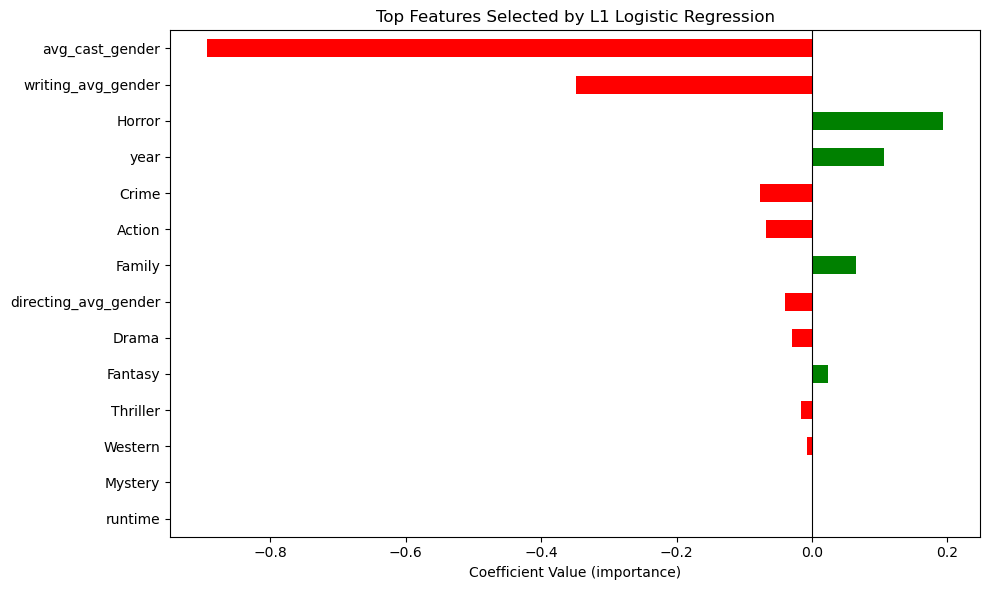

In [ ]:
important_coefs = model_cv.coef_[0] 
coef_series = pd.Series(important_coefs, index=X.columns)

# Filter non-zero coefficients (selected features)
selected_coefs = coef_series[coef_series != 0]

# Sort by absolute importance
sorted_coefs = selected_coefs.reindex(selected_coefs.abs().sort_values(ascending=False).index)

# Plot as a horizontal bar chart
plt.figure(figsize=(10, 6))
sorted_coefs.plot(kind='barh', color=np.where(sorted_coefs > 0, 'green', 'red'))

plt.title("Top Features Selected by L1 Logistic Regression")
plt.xlabel("Coefficient Value (importance)")
plt.gca().invert_yaxis()  # Most important at top
plt.axvline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()


In [21]:
selected_coefs

year                    0.106254
runtime                 0.000591
Western                -0.007003
Crime                  -0.077305
Thriller               -0.015572
Action                 -0.068657
Horror                  0.193687
Fantasy                 0.023164
Mystery                 0.001149
Drama                  -0.030258
Family                  0.064957
avg_cast_gender        -0.893574
directing_avg_gender   -0.039856
writing_avg_gender     -0.348867
dtype: float64

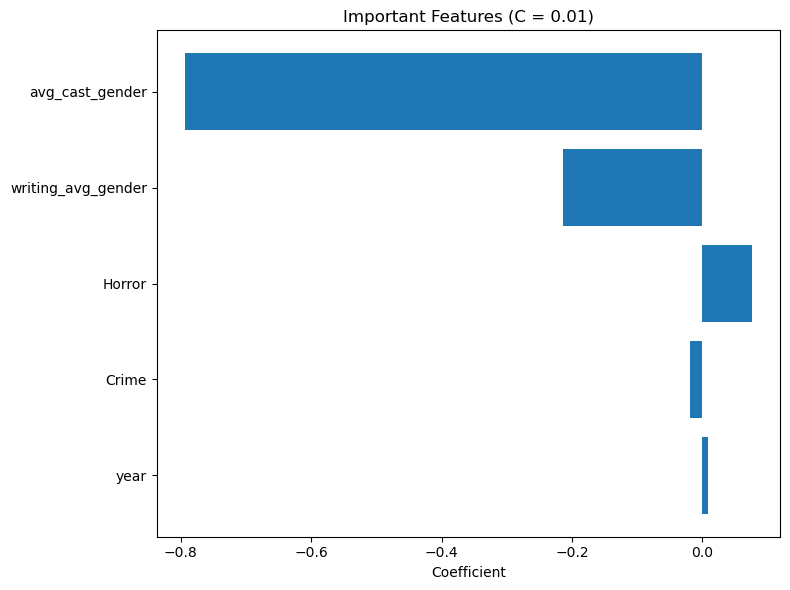

In [19]:

# want to look at the features specifically for the c of .01
model_001 = LogisticRegression(penalty='l1', solver='liblinear', C=0.01, max_iter=1000)
model_001.fit(X_train, y_train)

# Get coefficients
coefs01 = model_001.coef_[0]
coef_df01 = pd.DataFrame({
    'feature': X.columns,
    'coefficient': coefs01
})

# Filter out zero coefficients
important_features01 = coef_df01[coef_df01['coefficient'] != 0]

# Sort by importance
important_features01 = important_features01.reindex(
    important_features01['coefficient'].abs().sort_values(ascending=False).index
)

plt.figure(figsize=(8, 6))
plt.barh(important_features01['feature'], important_features01['coefficient'])
plt.xlabel('Coefficient')
plt.title('Important Features (C = 0.01)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [23]:
important_features01

,feature,coefficient
20,avg_cast_gender,-0.793466
23,writing_avg_gender,-0.214254
11,Horror,0.075777
5,Crime,-0.019078
0,year,0.009219


Notably, Mystery and runtime have really low values of importance, but the model hasn't shrunk it all the way to zero.

In [12]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = model_cv.predict(X_test)
y_prob = model_cv.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.66      0.75      0.70       390
           1       0.76      0.67      0.71       455

    accuracy                           0.71       845
   macro avg       0.71      0.71      0.71       845
weighted avg       0.71      0.71      0.71       845

ROC AUC: 0.7702451394759087


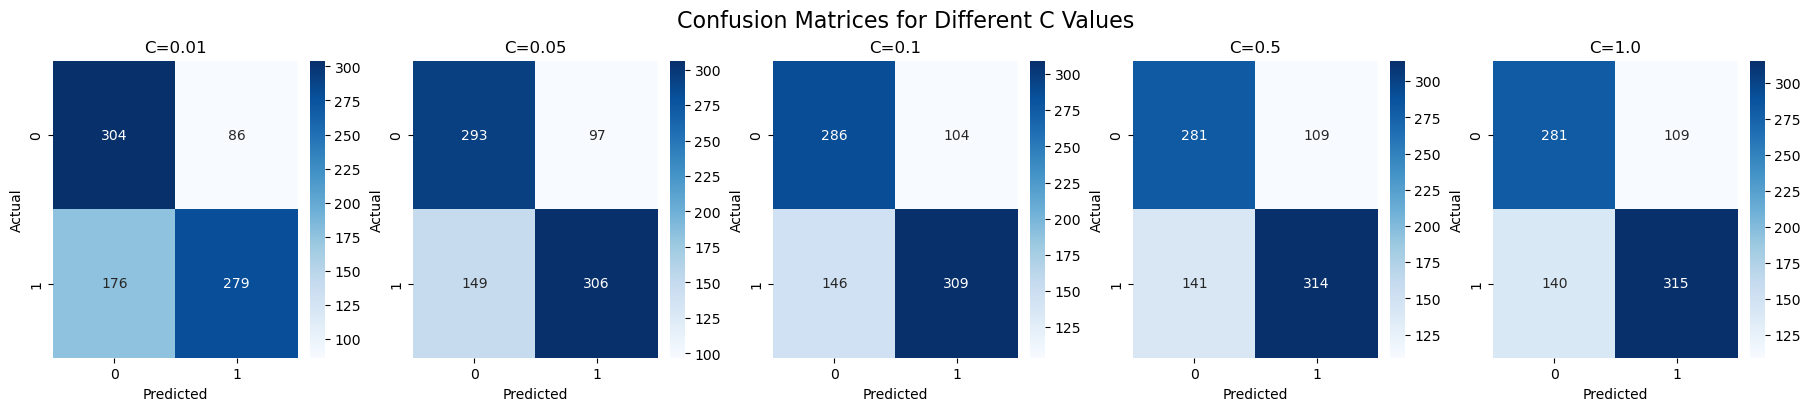

In [13]:

# Your list of C values
c_values = [0.01, 0.05, 0.1, 0.5, 1.0]

# Prepare for plotting
fig, axes = plt.subplots(1, len(c_values), figsize=(18, 4), constrained_layout=True)

# Optionally use cross-validation or just use the whole training set
for i, C in enumerate(c_values):
    model = LogisticRegression(penalty='l1', solver='liblinear', C=C)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'C={C}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.suptitle("Confusion Matrices for Different C Values", fontsize=16)
plt.show()

In [17]:
for C in c_values:
    model = LogisticRegression(penalty='l1', solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n=== Classification Report for C = {C:.4f} ===")
    print(classification_report(y_test, y_pred, digits=3))


=== Classification Report for C = 0.0100 ===
              precision    recall  f1-score   support

           0      0.633     0.779     0.699       390
           1      0.764     0.613     0.680       455

    accuracy                          0.690       845
   macro avg      0.699     0.696     0.690       845
weighted avg      0.704     0.690     0.689       845


=== Classification Report for C = 0.0500 ===
              precision    recall  f1-score   support

           0      0.663     0.751     0.704       390
           1      0.759     0.673     0.713       455

    accuracy                          0.709       845
   macro avg      0.711     0.712     0.709       845
weighted avg      0.715     0.709     0.709       845


=== Classification Report for C = 0.1000 ===
              precision    recall  f1-score   support

           0      0.662     0.733     0.696       390
           1      0.748     0.679     0.712       455

    accuracy                          0.704 

next lets look at the ROC curve for the c value of .05

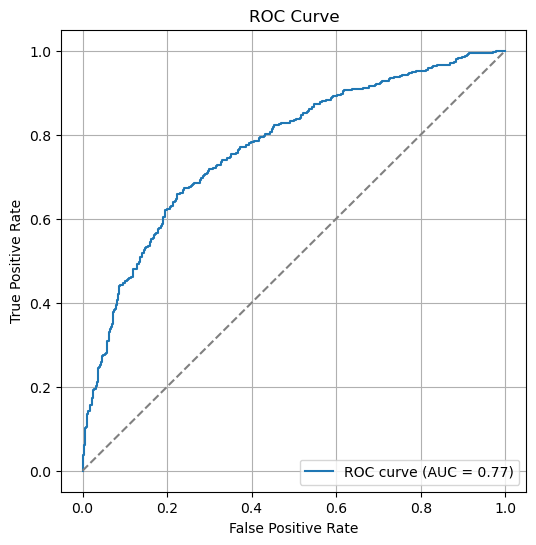

In [15]:
y_proba = model_cv.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

# Plot
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

How does that ROC curve compare to the ROC curves for the other models?

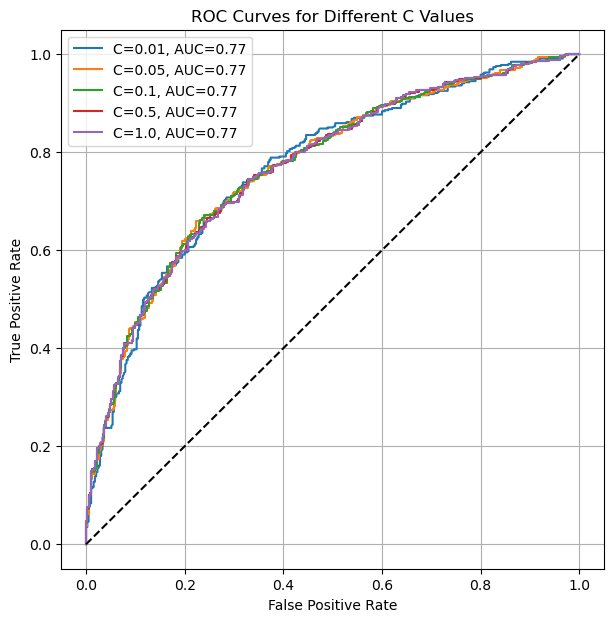

In [16]:
from sklearn.linear_model import LogisticRegression

c_values = [0.01, 0.05, 0.1, 0.5, 1.0]
plt.figure(figsize=(7, 7))

for C in c_values:
    model = LogisticRegression(penalty='l1', solver='liblinear', C=C)
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc_score = roc_auc_score(y_test, y_proba)
    
    plt.plot(fpr, tpr, label=f'C={C}, AUC={auc_score:.2f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different C Values')
plt.legend()
plt.grid(True)
plt.show()

So it looks like even though the accuracy changes depending on the value of C, the ROC curve doesn't